## Visualizing the Model Predictions

#### Primary Goal: Visualize and inspect the model predictions 
In this notebook, I'll brief tutorial for making 2D visualizations of the ML model predictions. 

In [224]:
# Import packages 
import pandas as pd
import numpy as np
import netCDF4
import h5netcdf
import xarray as xr
from os.path import join
import joblib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import shapely
import cartopy
%matplotlib inline
import datetime as dt

# We add the github package to our system path so we can import python scripts for that repo. 
import sys
sys.path.append('/home/samuel.varga/projects/2to6_hr_severe_wx/')
sys.path.append('/home/samuel.varga/python_packages/ml_workflow/')
sys.path.append('/home/samuel.varga/python_packages/MontePython/')
sys.path.append('/home/samuel.varga/python_packages/WoF_post') #WoF post package
sys.path.append('/home/samuel.varga/python_packages/wofs_ml_severe/')
sys.path.append('/home/samuel.varga/python_packages/VargaPy/')
from main.io import load_ml_data

from VargaPy.MlUtils import Drop_Unwanted_Variables, get_bl_col, pseudo_all_severe_probs

In [225]:
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

In [226]:
from wofs.plotting.wofs_colors import WoFSColors
from wofs_ml_severe.data_pipeline.storm_report_loader import StormReportLoader
from wofs_ml_severe.data_pipeline.storm_report_downloader import StormReportDownloader

In [227]:
# Configuration variables (You'll need to change based on where you store your data)
#base_path = '/work/mflora/ML_2TO6HR/data'
TIMESCALE='2to6'
FRAMEWORK='POTVIN'
date='20190520'
#19-03
init_time='0200'
hazard='all'
scale='36km'
SigSev=False
hazard_name=f'{hazard}_{"sig_severe" if SigSev else "severe"}'
base_path=f'/work/samuel.varga/data/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}/Single/{init_time}'
outlook_dir=f'/work/samuel.varga/data/{TIMESCALE}_hr_severe_wx/SPC_outlooks'

# To Do List:
Update Init time label
Update threshold label for all severe
Update hazard scale and time scale in plot label

### Load the data for the ML model and BL model.

In [228]:
# Set the target column and baseline variable. 
bl_column=None #manually set baseline column if using something other than standard all-sev or indiv-haz
if bl_column is None: 
    bl_column = get_bl_col(target_scale=scale[0:-2:1], hazard_name=hazard_name, timescale=TIMESCALE)
    wind_bl = get_bl_col(target_scale=scale[0:-2:1], hazard_name='wind_severe', timescale=TIMESCALE)
    hail_bl = get_bl_col(target_scale=scale[0:-2:1], hazard_name='hail_severe', timescale=TIMESCALE)
    tornado_bl=get_bl_col(target_scale=scale[0:-2:1], hazard_name='tornado_severe', timescale=TIMESCALE)

# Load the testing dataset for the ML model.
X, X_bl = load_ml_data(base_path=base_path, 
                       date=date,  
                       bl_column = bl_column, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE)
__, wind_bl = load_ml_data(base_path=base_path, date=date,  bl_column = wind_bl, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE)
__, hail_bl = load_ml_data(base_path=base_path, date=date,  bl_column = hail_bl, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE)
__, tornado_bl = load_ml_data(base_path=base_path, date=date,  bl_column = tornado_bl, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE)

In [229]:
#dates=[#'20180511', '20180514', '20180521', '20180531', '20190501','20190502',
#'20190508','20190526','20190510', '20190515', '20190520',      
#'20190521', '20190523', '20200506', '20200507','20200508', '20200519',
#'20200529', '20210504', '20210507', '20210510', '20210513', '20210520', 
#'20210521', '20210523']

## Selection of Variables

The current dataset contains both the old 90th percentile (ens_90th), which was calculated with regression. (See nanpercentile for more information), as well as the new 90th percentile (ens_16th), 10th percentile (ens_2nd), and IQR (ens_iqr) for intrastorm variables. If original is set to true, all new variables are dropped and the old 90th percentile feature is used. If original is set to false, all new variables are used and the old 90th percentile feature is dropped. This allows us to create a control using the original variables, so that we can assess the impact of the new variables.

In [230]:
ts='all'
intrastormOnly=False
envOnly=False
X, ts_suff, var_suff = Drop_Unwanted_Variables(X, original=False, training_scale=None if ts=='all' else ts[0:-2:1], intrastormOnly=intrastormOnly, envOnly=envOnly)
print(var_suff)

Using new variables- dropping old 90th percentile
(10000, 174)
all
control


### Load the ML model and BL model.

In [231]:
def get_bl_pred(X_bl, shape, hazard, scale='36km', FRAMEWORK=None, TIMESCALE=None):
    in_path=f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}/blModels/'
    # Load the baseline model. 
    bl_model = joblib.load(join(in_path,f'{hazard}_baseline_model_{scale}.joblib')) #Update naming of BL models
    bl_pred = bl_model.predict(X_bl)
    bl_pred_2D = bl_pred.reshape(shape)
    
    return bl_pred_2D

def get_ml_pred(X, shape, hazard, scale='36km', model='hist', FRAMEWORK=None, TIMESCALE=None, ts_suff=None, var_suff=None):
    in_path=f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}/mlModels/{scale}/'
    print(join(in_path,f'Varga_{ts_suff}_{model}_{hazard}_{scale}_Sev_{var_suff}_0.joblib'))
    # Load the ML model.
    ml_data = joblib.load(join(in_path,f'Varga_{ts_suff}_{model}_{hazard}_{scale}_Sev_{var_suff}_0.joblib')) #Change this to own path
    # When the ML model is saved by the CalibratedPipelineHyperOptCV package, 
    # there are additional metadata that is stored with it. 
    # We want to load the model and the features. 
    # We want to make sure the X input as the features in correct order. 
    ml_model = ml_data['model']
    #print(dir(ml_model.base_estimator.named_steps['model']))
    features = ml_data['X'].columns
    #features = ml_data['features']
    X = X[features]
    
    ml_pred = ml_model.predict_proba(X)[:,1]
    ml_pred_2D = ml_pred.reshape(shape)
    
    return ml_pred_2D


#ml_data = joblib.load(join(base_path, f'mlModels/{scale}/Varga_{ts}_{name}_{hazard}_{scale}_{"SigSev" if SigSevere else "control"}_{model_ind}.joblib'))
#ml_data = joblib.load(join(base_path, f'mlModels/{scale}/Varga_{ts}_{name}_{hazard}_{scale}_{"SigSev" if SigSevere else "Sev"}_{var_suff}_{model_ind}{"_DBRS" if Tkm else ""}.joblib'))

In [232]:
from glob import glob

if TIMESCALE=='0to3':
    indir = glob(f'/work/mflora/SummaryFiles/{date}/{init_time}/wofs_ENS_00*')[0] #0000 of the next day
else:
    indir = glob(f'/work/mflora/SummaryFiles/{date}/{init_time}/wofs_ENS_24*')[0] #0000 of the next day
print(indir)
#indir = glob(f'/work/samuel.varga/data/2to6_hr_severe_wx/SummaryFiles/{date}/{init_time}/wofs_ENS_24*')[0]

ds = xr.load_dataset(indir, decode_times=False)
lats = ds['xlat'][::3, ::3]
lons = ds['xlon'][::3, ::3]

shape = (len(lons), len(lats))

central_longitude = ds.attrs['STAND_LON']
central_latitude = ds.attrs['CEN_LAT']

standard_parallels = (ds.attrs['TRUELAT1'], ds.attrs['TRUELAT2'])
projection=ccrs.LambertConformal(central_longitude=central_longitude,
                                 central_latitude=central_latitude,
                                 standard_parallels=standard_parallels)
crs = ccrs.PlateCarree()
data_path = '/home/monte.flora/python_packages/WoF_post/wofs/data/'
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces")

county_file = join(data_path,'COUNTIES', 'countyl010g')
reader = shpreader.Reader(county_file)
shape_feature = ShapelyFeature(reader.geometries(),
                               crs, facecolor='none', linewidth=0.2, edgecolor='black', )

def add_map_stuff(ax, states, shape_feature):
    ax.add_feature(states, linewidth=.1, facecolor='none', edgecolor="black")
    ax.add_feature(cfeature.LAKES, linewidth=.1, facecolor='none', edgecolor="black")
    ax.add_feature(cfeature.COASTLINE, linewidth=.1, facecolor='none', edgecolor="black")        
    ax.add_feature(shape_feature)
    
    
def set_extent(ax, projection , crs, lat, lons,):
    """ Set the Map extent based the WoFS domain """
    # Set the extent. 
    xs, ys, _ = projection.transform_points(
            crs,
            np.array([lons.min(), lons.max()]),
            np.array([lats.min(), lats.max()])).T
    _xlimits = xs.tolist()
    _ylimits = ys.tolist()

    # The limit is max(lower bound), min(upper bound). This will create 
    # a square plot and make sure there is no white spaces between the map
    # the bounding box created by matplotlib. This also allows us to set the
    # WoFS domain boundaries in cases where we aren't plotting WoFS data 
    # (e.g., storm reports, warning polygons, etc.) 
    lims = (max([_xlimits[0]]+[_ylimits[0]]),min([_xlimits[-1]]+[_ylimits[-1]]))
        
    ax.set_xlim(lims)
    ax.set_ylim(lims) 
    
    return ax #0000 is 0000 the next day

/work/mflora/SummaryFiles/20190520/0200/wofs_ENS_24_20190521_0200_0400.nc


In [233]:
#help(StormReportDownloader)

In [234]:
#Get the storm reports-- Should add a check to grab data if it isn't in directory
#StormReportDownloader('/work/samuel.varga/data/2to6_hr_severe_wx/reports/').get_storm_events(years=[2017])

In [235]:
deltat=5
from scipy.ndimage import uniform_filter, maximum_filter 
#from WoF_post.wofs.verification.lsrs.get_storm_reports import StormReports
#from WoF_post.wofs.plotting.util import decompose_file_path
#from WoF_post.wofs.plotting.wofs_colors import WoFSColors

from wofs.plotting.util import decompose_file_path
from wofs.plotting.wofs_colors import WoFSColors
from wofs.verification.lsrs.get_storm_reports import StormReports

# Get the storm reports. 
comps = decompose_file_path(indir)


print(init_time)
print(comps['VALID_DATE']+comps['VALID_TIME'])

start_time=(pd.to_datetime(comps['VALID_DATE']+comps['INIT_TIME'])+dt.timedelta(minutes=int(comps['TIME_INDEX'])*deltat)).strftime('%Y%m%d%H%M')
print(start_time)

forecast_length=180 if TIMESCALE=='0to3' else 240


    
report = StormReportLoader(initial_time=start_time, 
            forecast_length=forecast_length, 
            err_window=15, 
            reports_path='/work/mflora/LSRS/StormEvents_2017-2022.csv', #.format(str(date)[0:4]), #change this
            report_type='NOAA'
            )

ds = xr.load_dataset(indir, decode_times=False)
points = report()

0200
201905210400
201905210400


In [236]:
start_date=(pd.to_datetime(comps['VALID_DATE']+comps['INIT_TIME'])+dt.timedelta(minutes=int(comps['TIME_INDEX'])*deltat)) #Beginning of forecast window
end_date=(start_date+dt.timedelta(minutes=forecast_length)).strftime('%Y%m%d%H%M') #End of forecast window
print((start_date, end_date))
title = f'Valid: {start_time[:4]}-{start_time[4:6]}-{start_time[6:8]} {start_time[8:10]}:{start_time[10:12]} - {end_date[8:10]}:{end_date[10:12]} UTC'
#This will show as start_date start_time - end_time, even if end_time is on the next day        
print(title)

(Timestamp('2019-05-21 04:00:00'), '201905210800')
Valid: 2019-05-21 04:00 - 08:00 UTC


In [237]:
titles = {'hail' : 'Severe Hail', 
         'wind' : 'Severe Wind', 
         'tornado' : 'Tornado',
         'all': 'All Severe'}

baseline_names = {'hail' : 'Calibrated NMEP (45 km) of HAILCAST > 1.25 in',
                  'wind' : 'Calibrated NMEP (45 km) of 80-m wind speed > 50 kts',
                  'tornado' : r'Calibrated NMEP (27 km) of UH > 200 $m^2 s^{-2}$',
                  'all' : r'Calibrated NMEP (45 KM) of UH > 150 $m^2 s^{-2}$'
                 } #Need to update the UH threshold title

In [238]:
#rprt_df=geo_df.copy()
#points[hazard].shape

## Circle Methods

In [239]:
def circleofRadius(lat, lon, radiuskm):
    latArray=np.array([])
    lonArray=np.array([])
    for brng in range(0,360):
        lat2, lon2 = getLocation(lat,lon,brng, radiuskm)
        latArray=np.append(latArray, lat2)
        lonArray=np.append(lonArray, lon2)
    return lonArray, latArray
        
def getLocation(lat1, lon1, brng, radiuskm):
    lat1=lat1*np.pi/180.0
    lon1=lon1*np.pi/180.0
    R=6378.1 #radius of earth in km
    distancekm=radiuskm/R
    brng=(brng/90)*np.pi/2
    lat2=np.arcsin(np.sin(lat1)*np.cos(distancekm)+np.cos(lat1)*np.sin(distancekm)*np.cos(brng))
    lon2=lon1+np.arctan2(np.sin(brng)*np.sin(distancekm)*np.cos(lat1), np.cos(distancekm)-np.sin(lat1)*np.sin(lat2))
    lon2 = 180.0 * lon2/np.pi
    lat2 = 180.0*lat2/np.pi
    
    return lat2, lon2

In [240]:
#temp=gp.GeoDataFrame(_points) #Make a GDF of lat, lon
#temp['lat/lon'] = temp['lat.lon'].buffer(size) #Have to set df.crs, size depends on crs

# Grouped All-Severe from Individual Hazards

In [241]:
def get_pseudo_all_severe(name='logistic', TIMESCALE=TIMESCALE, FRAMEWORK=FRAMEWORK, scale=scale):
    '''Gets models trained for individual hazards to get all-severe probs'''
    in_path=f'/work/samuel.varga/projects/{TIMESCALE}_hr_severe_wx/{FRAMEWORK}/mlModels/{scale}/'
    ps_models=[]
    for hazard_ in ['wind','hail','tornado']:
        ind_haz_model=joblib.load(join(in_path, f'Varga_all_{name}_{hazard_}_{scale}_{"SigSev" if SigSev else "Sev"}_{var_suff}_0.joblib'))['model']
        ps_models.append(ind_haz_model)
    names=['wind','hail','tornado']
    ind_all=[(name, model) for name, model in zip(names, ps_models)]
    return ind_all

def get_pseudo_all_severe_probs(X, shape, name):
    ind_mods=get_pseudo_all_severe(name)
    pred=pseudo_all_severe_probs(models=ind_mods, X_test=X)
    pred=pred.reshape(shape)
    return pred


# SPC Convective Outlook Overlay

In [242]:
#outlook=SPCoutlook(date, 'cat', outlook_dir)
#outlook.outlook.shapeRecords()[0]
#outlook.outlook.shapes()[2].__geo_interface__

#feature = shape.shapeRecords()[0]
#first = feature.shape.__geo_interface__ 
#help(outlook.outlook)

In [243]:
#%matplotlib inline 
#fig, ax =plt.subplots()
#poly=outlook.outlook.shapes()[16].__geo_interface__
#x = [i for i,j in poly[0]]
#y = [j for i,j in poly[0]]
#ax.add_patch(PolygonPatch(poly, fc='red', ec='red', alpha=0.5, zorder=2))
#outlook.add_to_ax(ax)
#ax.plot(x,y)
#ax.axis('scaled')
#plt.show()

## Prediction Visualization for Hazards

/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/mlModels/36km/Varga_all_hist_all_36km_Sev_control_0.joblib
/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/mlModels/36km/Varga_all_logistic_all_36km_Sev_control_0.joblib


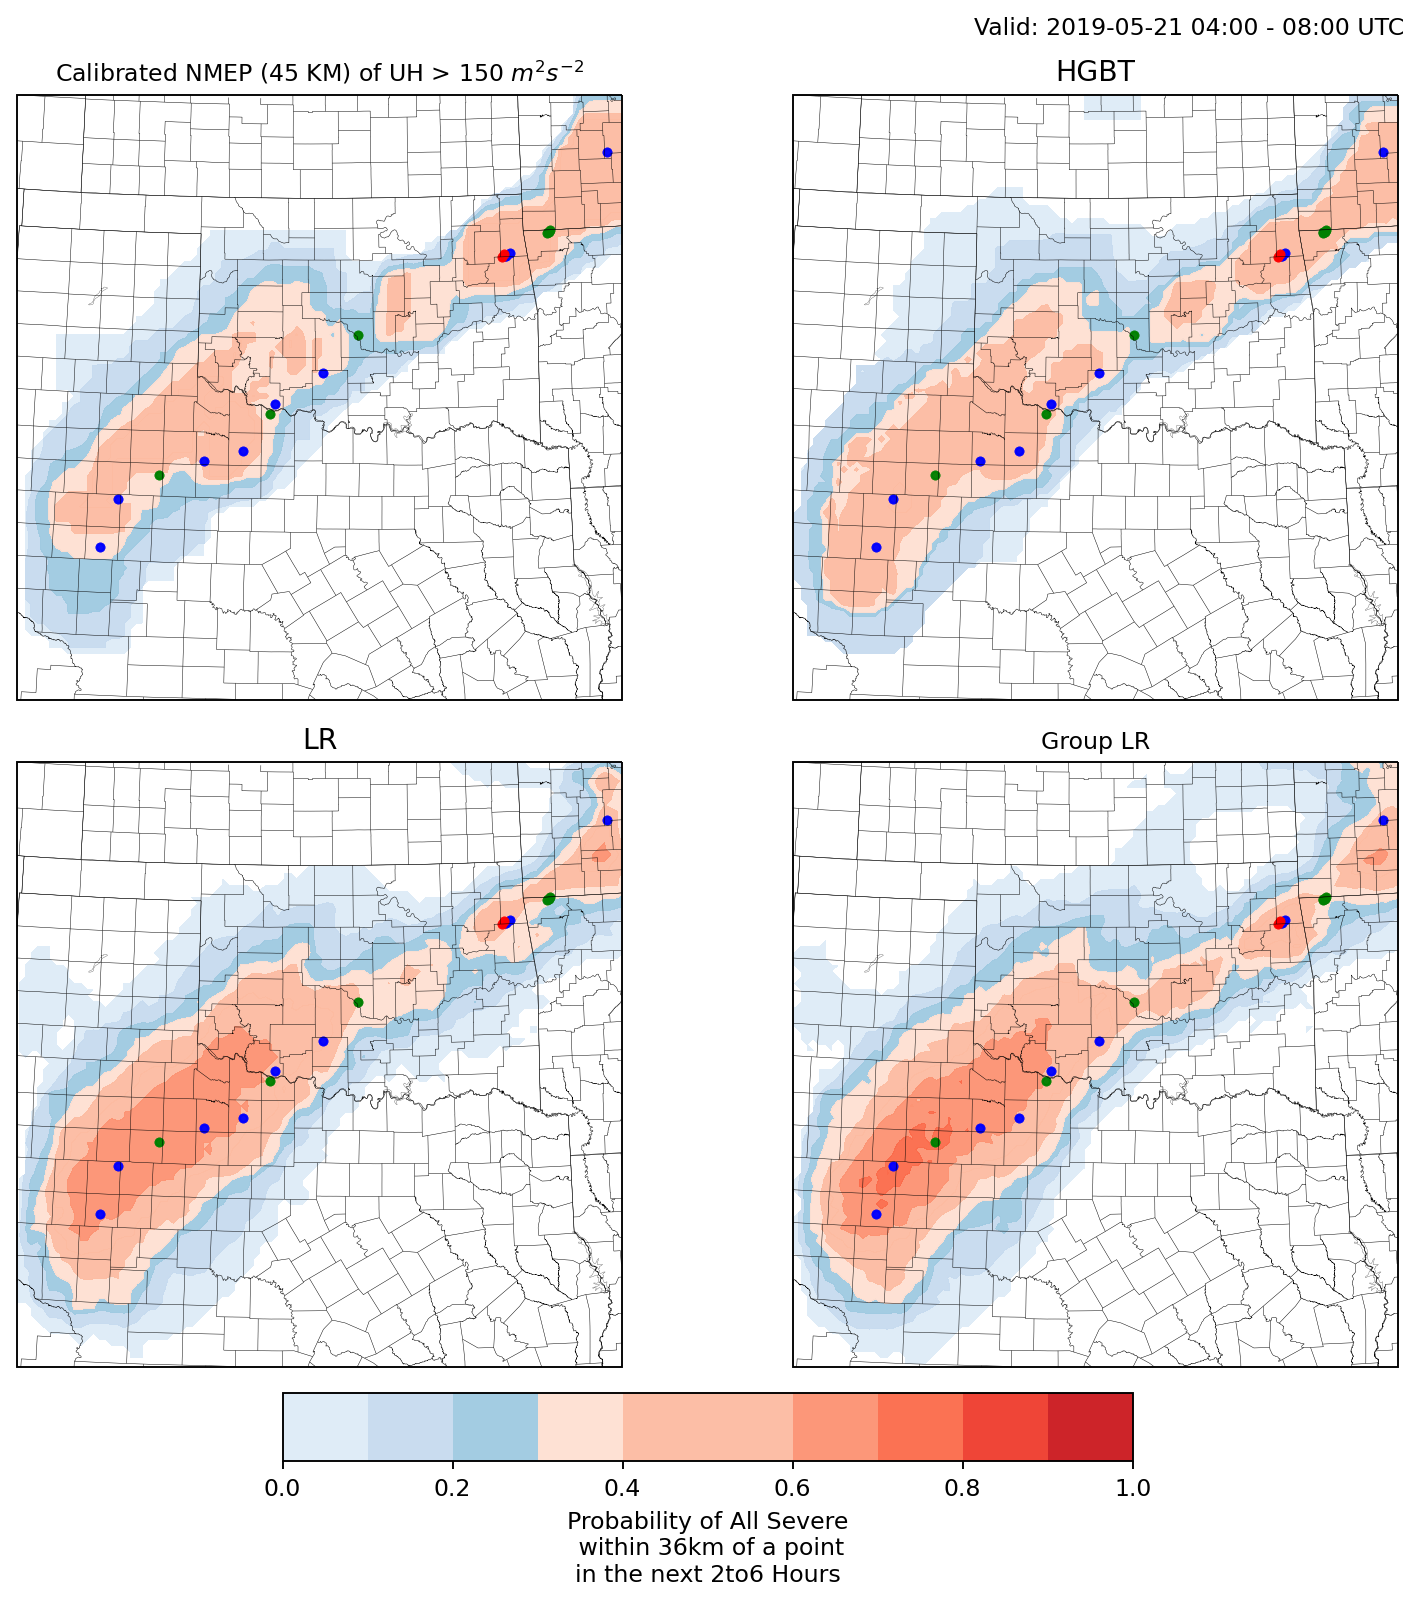

In [244]:
%matplotlib inline

hazard_color = {'hail' : 'g', 'wind': 'b', 'tornado': 'r'}
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=2, ncols=2, subplot_kw={'projection': projection},
                        constrained_layout=True)

models = ['BL', 'hist', 'logistic', 'group'] #random/ADAM
model_names = [baseline_names[hazard], 'HGBT', 'LR', 'Group LR']


if hazard != 'tornado':
    levels = np.arange(0, 1.1, 0.1)
else:
    levels = np.arange(0, 0.5, 0.001)  
    
# All 3 Models and BL
for ax, model, name in zip(axes.flat, models, model_names):
    if model == 'BL':
        pred = get_bl_pred(X_bl, shape, hazard, scale, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE)
    elif model== 'group':
        pred=get_pseudo_all_severe_probs(X, shape, 'logistic')
    
    else:
        pred = get_ml_pred(X, shape, hazard, scale, model, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE, ts_suff=ts_suff, var_suff=var_suff)
    
    add_map_stuff(ax, states, shape_feature)
    
    
    pred = np.ma.masked_where(pred<=0.025, pred)
    
    #cmap=WoFSColors.wz_cmap
    cf = ax.contourf(lons,lats, pred, cmap=WoFSColors.wz_cmap, alpha=0.95, levels=levels,
                transform = crs) 

    ##point_lat, point_lon = points[hazard]
    if hazard=='all':
        for Lorem in ['hail','wind','tornado']:
            _points=points[Lorem]
            ax.scatter(_points[:,1],_points[:,0], s=10, color=hazard_color[Lorem], alpha=0.8, zorder=1, transform=crs)
    else:
        _points = points[hazard]
        ax.scatter(_points[:,1],_points[:,0], s=900, color='k', alpha=0.8, zorder=1, transform=crs) #s=10
    
    
    ax = set_extent(ax, projection , crs, lats, lons,)
    fontsize = 10 if len(name) > 5 else 12
    ax.set_title(name, fontsize=fontsize)

fig.tight_layout()
#plt.subplots_adjust(hspace=0.2, wspace=0.0)
axes[0,1].annotate(title, (0.3, 1.1), xycoords='axes fraction', fontsize=10, color='k')

cax = fig.add_axes([0.25, -0.05, 0.5, 0.05])

fig.colorbar(cf, 
           cax=cax, 
             #label=f'Probability of any severe weather\n within {scale} of a point\nin the next 2-6 Hours',
           label=f'Probability of {titles[hazard]}\n within {scale} of a point\nin the next {TIMESCALE} Hours', 
          orientation='horizontal')

#Add 36/18/9km radius to storm reports
if False:
    for ax in axes.flat:  
        if All:
            for Lorem in ['hail','wind','tornado']:
                _points = points[Lorem]
                for pair in zip(_points[::3,1], _points[::3,0]):
                    repX, repY = circleofRadius(pair[1],pair[0], 36)
                    ax.plot(repX, repY, transform=crs, color='k', linewidth=1, alpha=0.5)
        else:
            for pair in zip(_points[:,1], _points[:,0]):
                repX, repY = circleofRadius(pair[1],pair[0], 36)
                ax.plot(repX, repY, transform=crs, color='k', linewidth=1)
plt.show()

/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/mlModels/36km/Varga_all_hist_wind_36km_Sev_control_0.joblib
/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/mlModels/36km/Varga_all_logistic_wind_36km_Sev_control_0.joblib


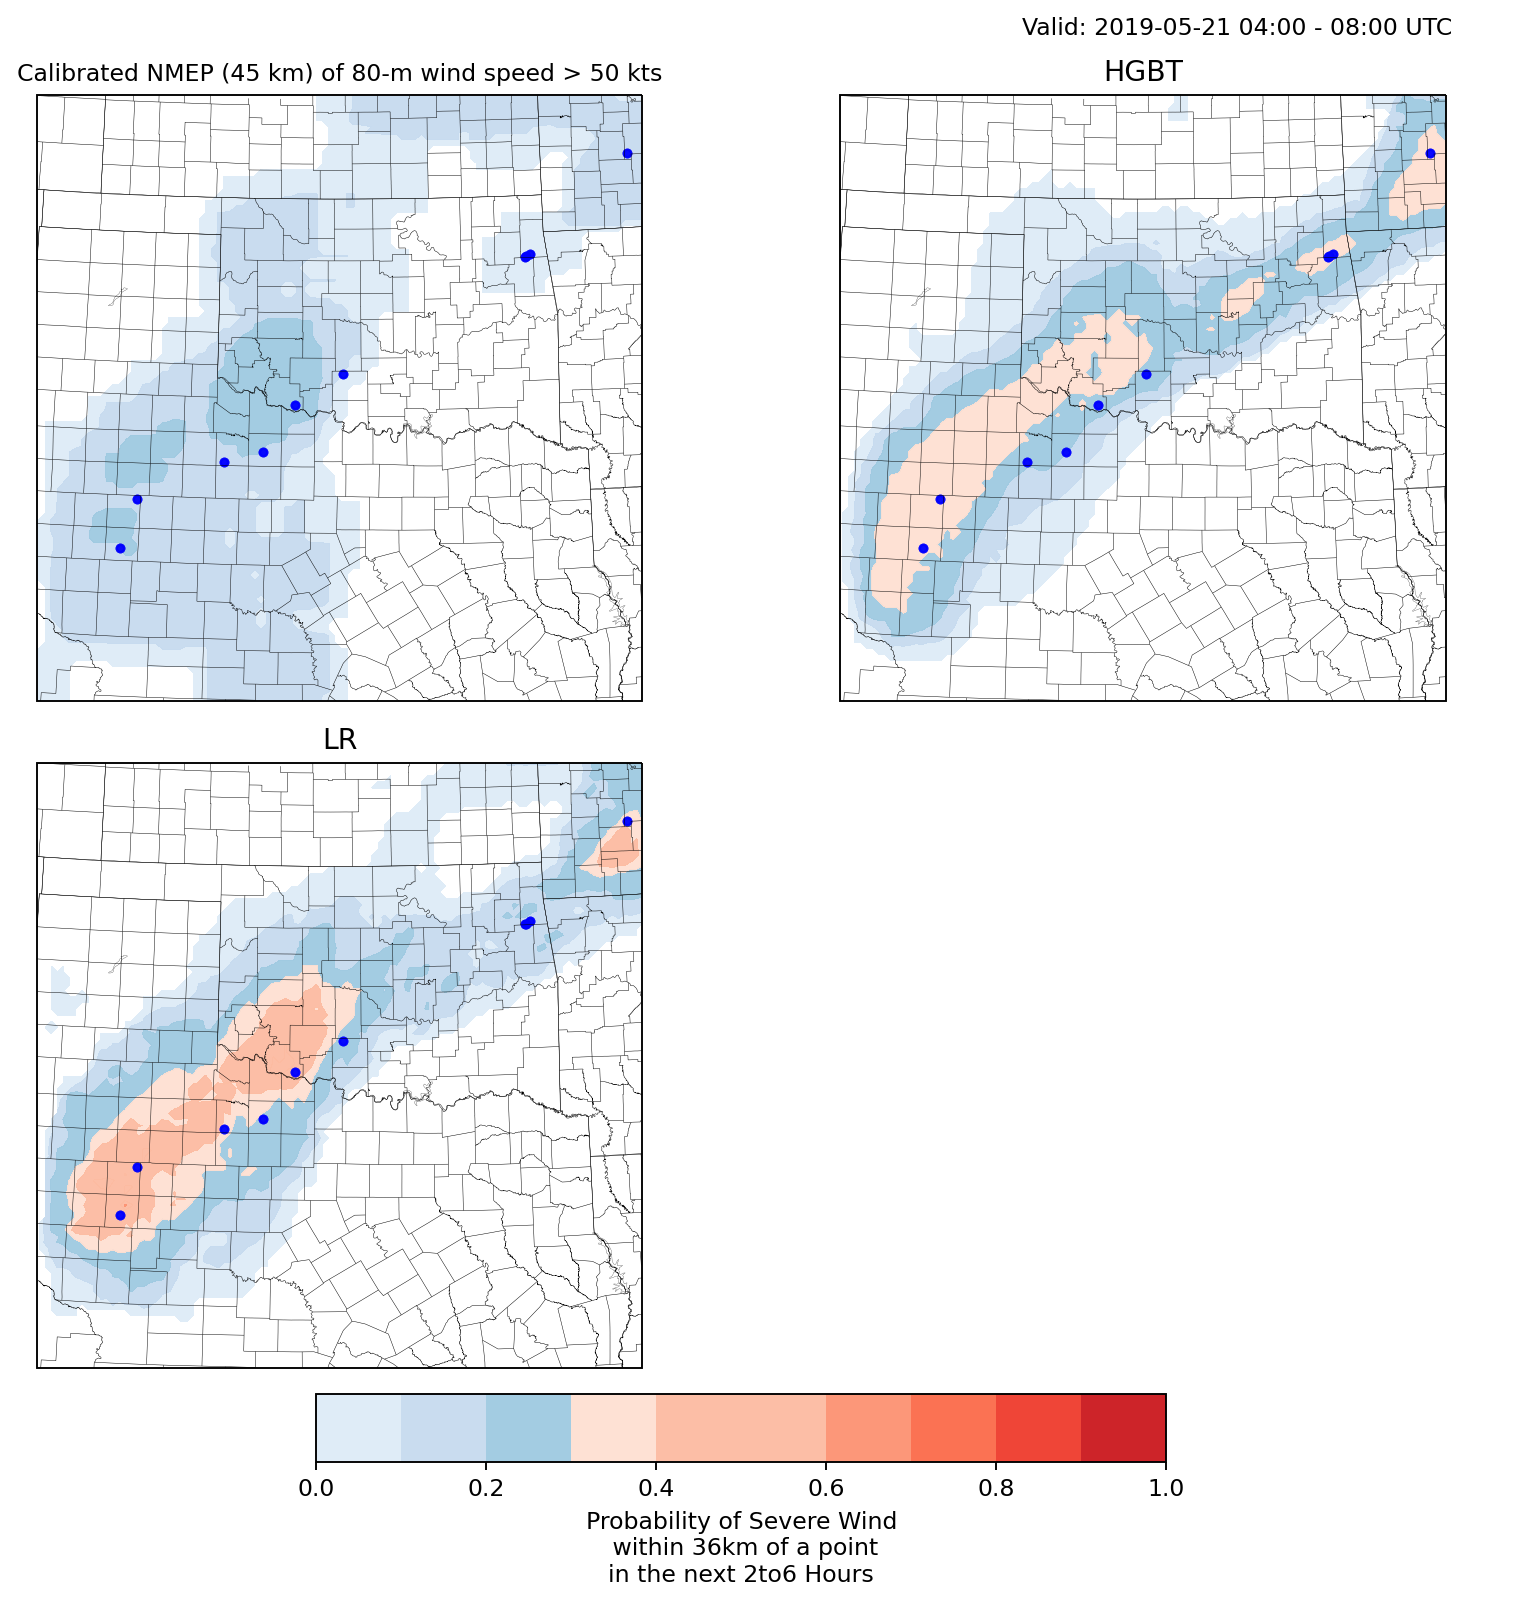

In [245]:
%matplotlib inline

fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=2, ncols=2, subplot_kw={'projection': projection},
                        constrained_layout=True)
hazard='wind'
models = ['BL', 'hist', 'logistic'] #random/ADAM
model_names = [baseline_names[hazard], 'HGBT', 'LR']


if hazard != 'tornado':
    levels = np.arange(0, 1.1, 0.1)
else:
    levels = np.arange(0, 0.5, 0.001)  
    
# All 3 Models and BL
for ax, model, name in zip(axes.flat, models, model_names):
    if model == 'BL':
        pred = get_bl_pred(wind_bl, shape, hazard, scale, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE)
    elif model== 'group':
        pred=get_pseudo_all_severe_probs(X, shape, 'logistic')
    
    else:
        pred = get_ml_pred(X, shape, hazard, scale, model, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE, ts_suff=ts_suff, var_suff=var_suff)
    
    add_map_stuff(ax, states, shape_feature)
    
    
    pred = np.ma.masked_where(pred<=0.025, pred)
    
    #cmap=WoFSColors.wz_cmap
    cf = ax.contourf(lons,lats, pred, cmap=WoFSColors.wz_cmap, alpha=0.95, levels=levels,
                transform = crs) 

    ##point_lat, point_lon = points[hazard]
    if hazard=='all':
        for Lorem in ['hail','wind','tornado']:
            _points=points[Lorem]
            ax.scatter(_points[:,1],_points[:,0], s=10, color=hazard_color[Lorem], alpha=0.8, zorder=1, transform=crs)
    else:
        _points = points[hazard]
        ax.scatter(_points[:,1],_points[:,0], s=10, color=hazard_color[hazard], alpha=0.8, zorder=1, transform=crs) #s=10
    
    
    ax = set_extent(ax, projection , crs, lats, lons,)
    fontsize = 10 if len(name) > 5 else 12
    ax.set_title(name, fontsize=fontsize)

fig.tight_layout()
#plt.subplots_adjust(hspace=0.2, wspace=0.0)
axes[0,1].annotate(title, (0.3, 1.1), xycoords='axes fraction', fontsize=10, color='k')

cax = fig.add_axes([0.25, -0.05, 0.5, 0.05])

fig.colorbar(cf, 
           cax=cax, 
             #label=f'Probability of any severe weather\n within {scale} of a point\nin the next 2-6 Hours',
           label=f'Probability of {titles[hazard]}\n within {scale} of a point\nin the next {TIMESCALE} Hours', 
          orientation='horizontal')

#Add 36/18/9km radius to storm reports
if False:
    for ax in axes.flat:  
        if All:
            for Lorem in ['hail','wind','tornado']:
                _points = points[Lorem]
                for pair in zip(_points[::3,1], _points[::3,0]):
                    repX, repY = circleofRadius(pair[1],pair[0], 36)
                    ax.plot(repX, repY, transform=crs, color='k', linewidth=1, alpha=0.5)
        else:
            for pair in zip(_points[:,1], _points[:,0]):
                repX, repY = circleofRadius(pair[1],pair[0], 36)
                ax.plot(repX, repY, transform=crs, color='k', linewidth=1)
axes[-1, -1].axis('off')
plt.show()

/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/mlModels/36km/Varga_all_hist_hail_36km_Sev_control_0.joblib
/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/mlModels/36km/Varga_all_logistic_hail_36km_Sev_control_0.joblib


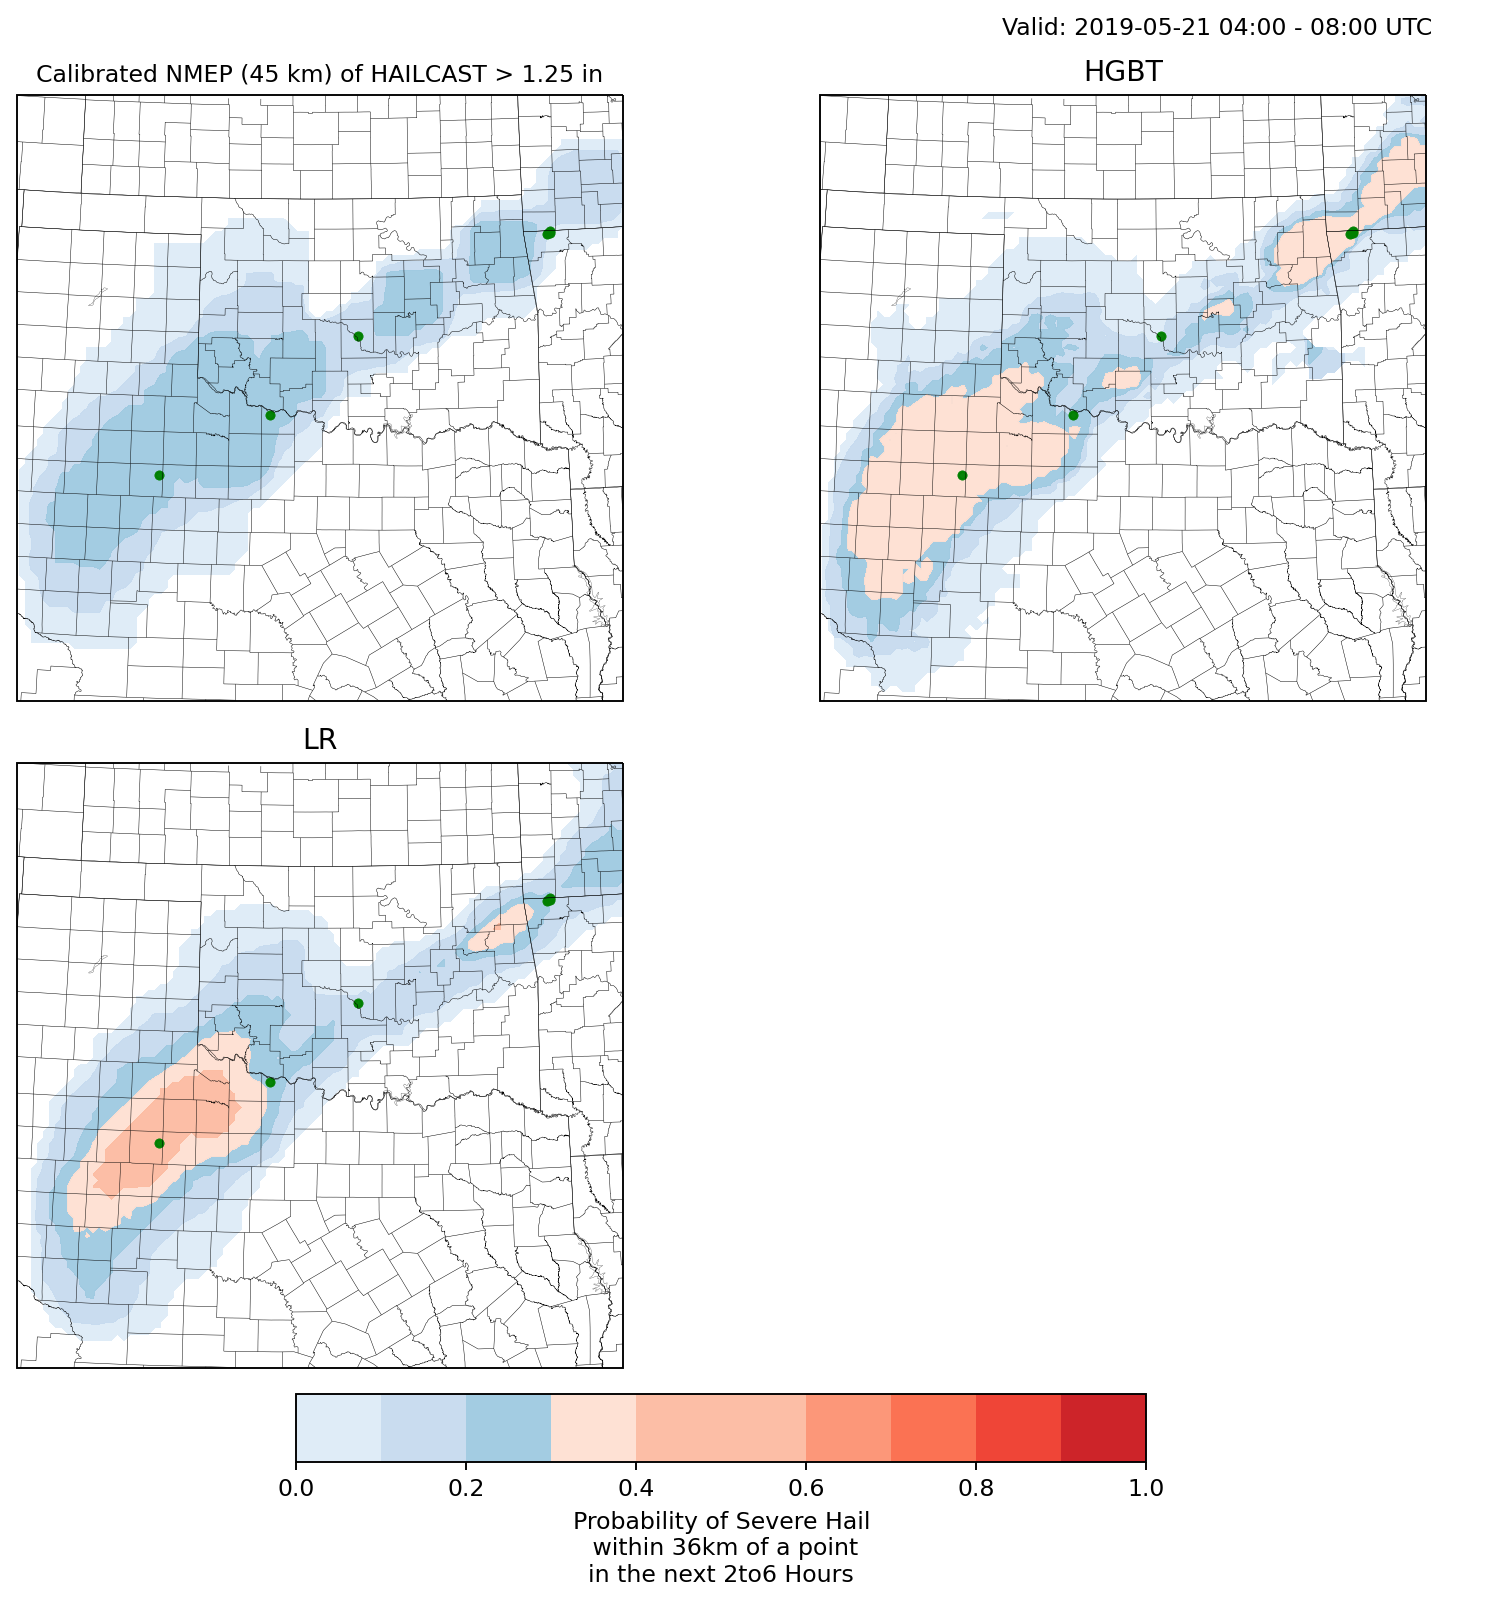

In [246]:
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=2, ncols=2, subplot_kw={'projection': projection},
                        constrained_layout=True)
hazard='hail'
model_names = [baseline_names[hazard], 'HGBT', 'LR']

if hazard != 'tornado':
    levels = np.arange(0, 1.1, 0.1)
else:
    levels = np.arange(0, 0.5, 0.001)  
    
# All 3 Models and BL
for ax, model, name in zip(axes.flat, models, model_names):
    if model == 'BL':
        pred = get_bl_pred(hail_bl, shape, hazard, scale, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE)
    elif model== 'group':
        pred=get_pseudo_all_severe_probs(X, shape, 'logistic')
    
    else:
        pred = get_ml_pred(X, shape, hazard, scale, model, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE, ts_suff=ts_suff, var_suff=var_suff)
    
    add_map_stuff(ax, states, shape_feature)
    
    
    pred = np.ma.masked_where(pred<=0.025, pred)
    
    #cmap=WoFSColors.wz_cmap
    cf = ax.contourf(lons,lats, pred, cmap=WoFSColors.wz_cmap, alpha=0.95, levels=levels,
                transform = crs) 

    ##point_lat, point_lon = points[hazard]
    if hazard=='all':
        for Lorem in ['hail','wind','tornado']:
            _points=points[Lorem]
            ax.scatter(_points[:,1],_points[:,0], s=10, color=hazard_color[Lorem], alpha=0.8, zorder=1, transform=crs)
    else:
        _points = points[hazard]
        ax.scatter(_points[:,1],_points[:,0], s=10, color=hazard_color[hazard], alpha=0.8, zorder=1, transform=crs) #s=10
    
    
    ax = set_extent(ax, projection , crs, lats, lons,)
    fontsize = 10 if len(name) > 5 else 12
    ax.set_title(name, fontsize=fontsize)

fig.tight_layout()
#plt.subplots_adjust(hspace=0.2, wspace=0.0)
axes[0,1].annotate(title, (0.3, 1.1), xycoords='axes fraction', fontsize=10, color='k')

cax = fig.add_axes([0.25, -0.05, 0.5, 0.05])

fig.colorbar(cf, 
           cax=cax, 
             #label=f'Probability of any severe weather\n within {scale} of a point\nin the next 2-6 Hours',
           label=f'Probability of {titles[hazard]}\n within {scale} of a point\nin the next {TIMESCALE} Hours', 
          orientation='horizontal')

#Add 36/18/9km radius to storm reports
if False:
    for ax in axes.flat:  
        if All:
            for Lorem in ['hail','wind','tornado']:
                _points = points[Lorem]
                for pair in zip(_points[::3,1], _points[::3,0]):
                    repX, repY = circleofRadius(pair[1],pair[0], 36)
                    ax.plot(repX, repY, transform=crs, color='k', linewidth=1, alpha=0.5)
        else:
            for pair in zip(_points[:,1], _points[:,0]):
                repX, repY = circleofRadius(pair[1],pair[0], 36)
                ax.plot(repX, repY, transform=crs, color='k', linewidth=1)
axes[-1, -1].axis('off')
plt.show()

/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/mlModels/36km/Varga_all_hist_tornado_36km_Sev_control_0.joblib
/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/mlModels/36km/Varga_all_logistic_tornado_36km_Sev_control_0.joblib


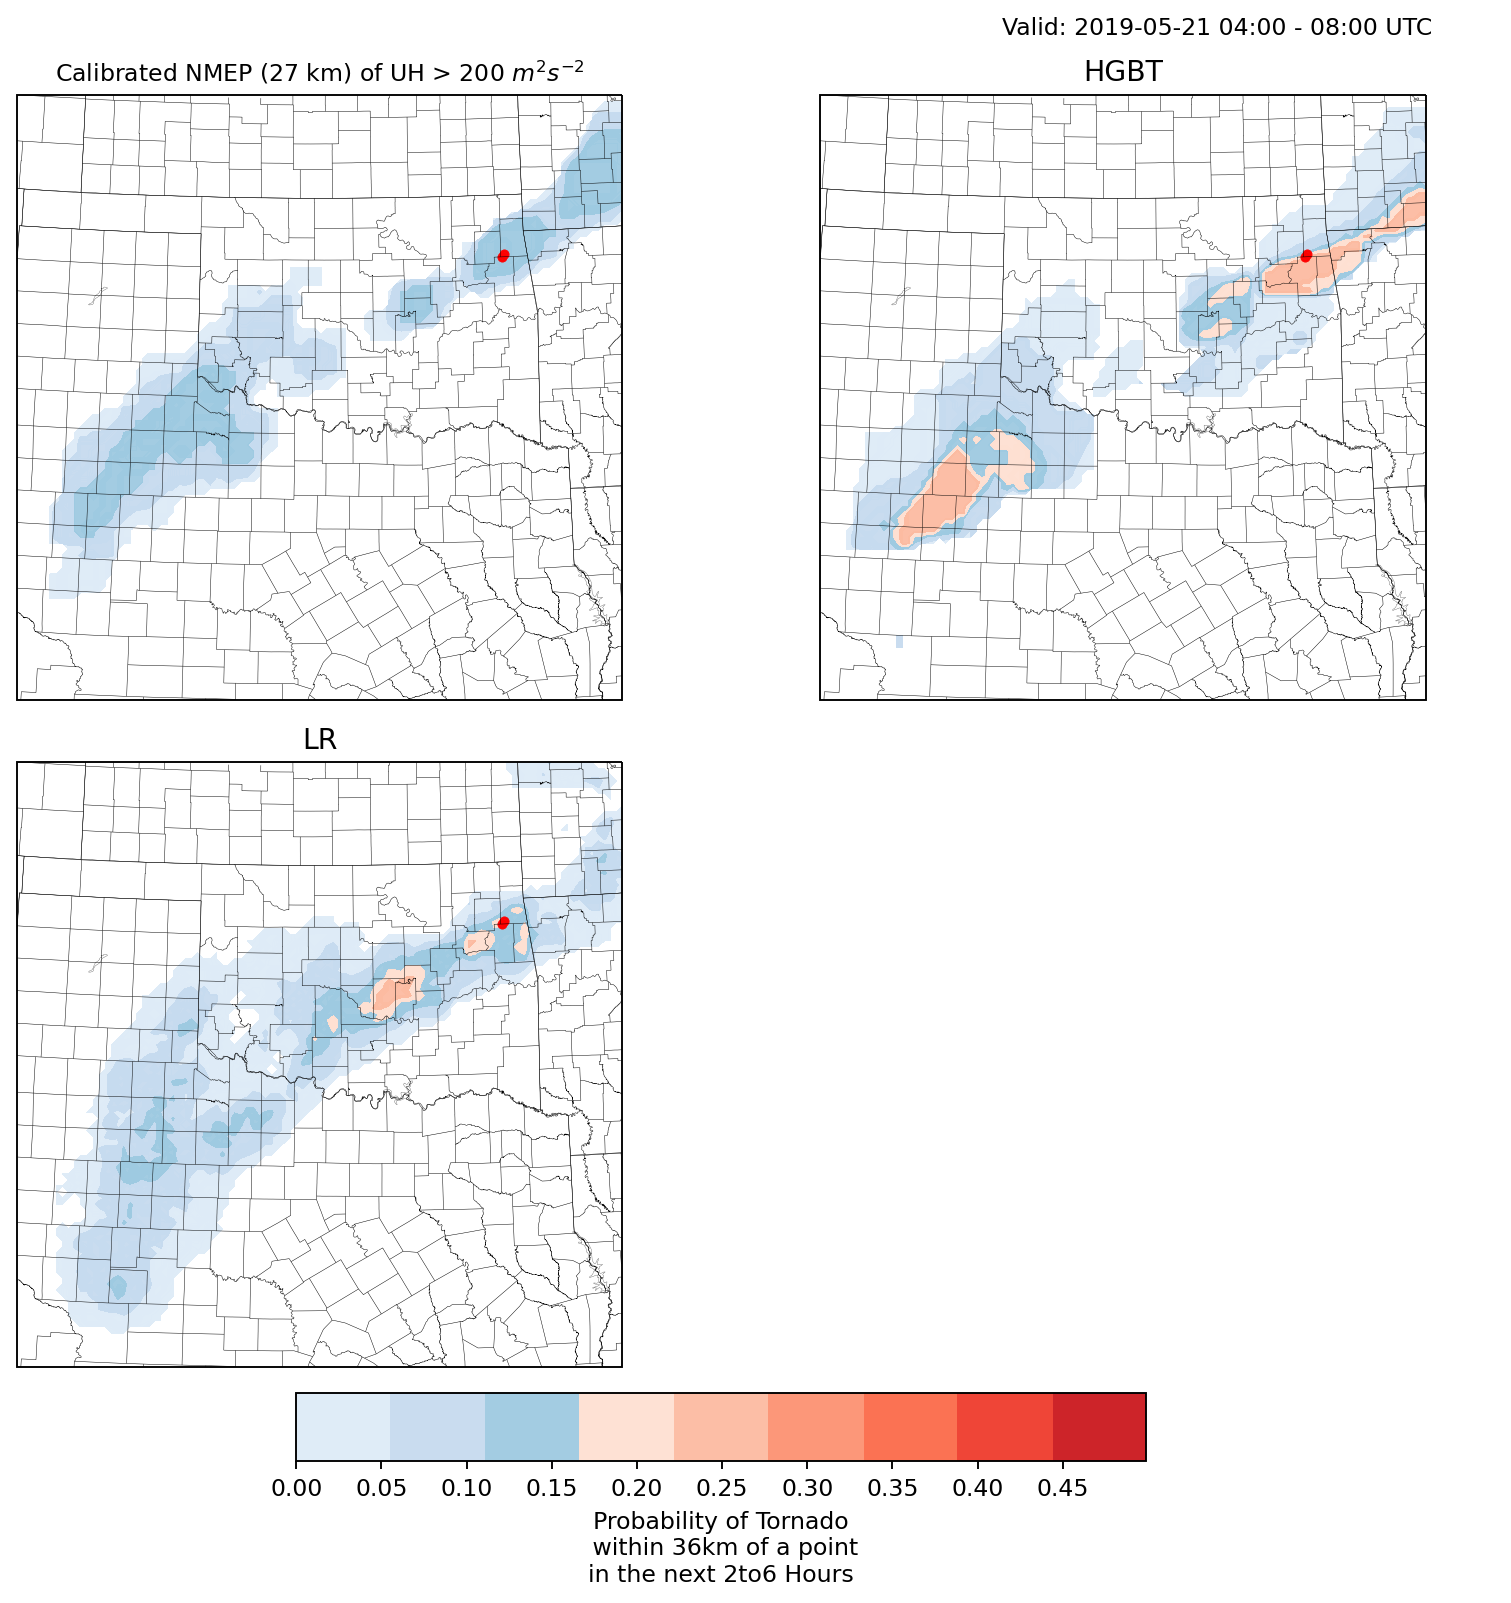

In [247]:
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=2, ncols=2, subplot_kw={'projection': projection},
                        constrained_layout=True)
hazard='tornado'
models = ['BL', 'hist', 'logistic'] 
model_names = [baseline_names[hazard], 'HGBT', 'LR']

if hazard != 'tornado':
    levels = np.arange(0, 1.1, 0.1)
else:
    levels = np.arange(0, 0.5, 0.001)  
    
# All 3 Models and BL
for ax, model, name in zip(axes.flat, models, model_names):
    if model == 'BL':
        pred = get_bl_pred(tornado_bl, shape, hazard, scale, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE)
    elif model== 'group':
        pred=get_pseudo_all_severe_probs(X, shape, 'logistic')
    
    else:
        pred = get_ml_pred(X, shape, hazard, scale, model, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE, ts_suff=ts_suff, var_suff=var_suff)
    
    add_map_stuff(ax, states, shape_feature)
    
    
    pred = np.ma.masked_where(pred<=0.025, pred)
    
    #cmap=WoFSColors.wz_cmap
    cf = ax.contourf(lons,lats, pred, cmap=WoFSColors.wz_cmap, alpha=0.95, levels=levels,
                transform = crs) 

    ##point_lat, point_lon = points[hazard]
    if hazard=='all':
        for Lorem in ['hail','wind','tornado']:
            _points=points[Lorem]
            ax.scatter(_points[:,1],_points[:,0], s=10, color=hazard_color[Lorem], alpha=0.8, zorder=1, transform=crs)
    else:
        _points = points[hazard]
        ax.scatter(_points[:,1],_points[:,0], s=10, color=hazard_color[hazard], alpha=0.8, zorder=1, transform=crs) #s=10
    
    
    ax = set_extent(ax, projection , crs, lats, lons,)
    fontsize = 10 if len(name) > 5 else 12
    ax.set_title(name, fontsize=fontsize)

fig.tight_layout()
#plt.subplots_adjust(hspace=0.2, wspace=0.0)
axes[0,1].annotate(title, (0.3, 1.1), xycoords='axes fraction', fontsize=10, color='k')

cax = fig.add_axes([0.25, -0.05, 0.5, 0.05])

fig.colorbar(cf, 
           cax=cax, 
             #label=f'Probability of any severe weather\n within {scale} of a point\nin the next 2-6 Hours',
           label=f'Probability of {titles[hazard]}\n within {scale} of a point\nin the next {TIMESCALE} Hours', 
          orientation='horizontal')

#Add 36/18/9km radius to storm reports
if False:
    for ax in axes.flat:  
        if All:
            for Lorem in ['hail','wind','tornado']:
                _points = points[Lorem]
                for pair in zip(_points[::3,1], _points[::3,0]):
                    repX, repY = circleofRadius(pair[1],pair[0], 36)
                    ax.plot(repX, repY, transform=crs, color='k', linewidth=1, alpha=0.5)
        else:
            for pair in zip(_points[:,1], _points[:,0]):
                repX, repY = circleofRadius(pair[1],pair[0], 36)
                ax.plot(repX, repY, transform=crs, color='k', linewidth=1)
axes[-1, -1].axis('off')
plt.show()

# Predictor Scale Comparison

Using new variables- dropping old 90th percentile
(10000, 58)
9km
Using new variables- dropping old 90th percentile
(10000, 58)
45km
/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/mlModels/36km/Varga_all_logistic_all_36km_Sev_control_0.joblib
/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/mlModels/36km/Varga_9km_logistic_all_36km_Sev_control_0.joblib
/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/mlModels/36km/Varga_45km_logistic_all_36km_Sev_control_0.joblib


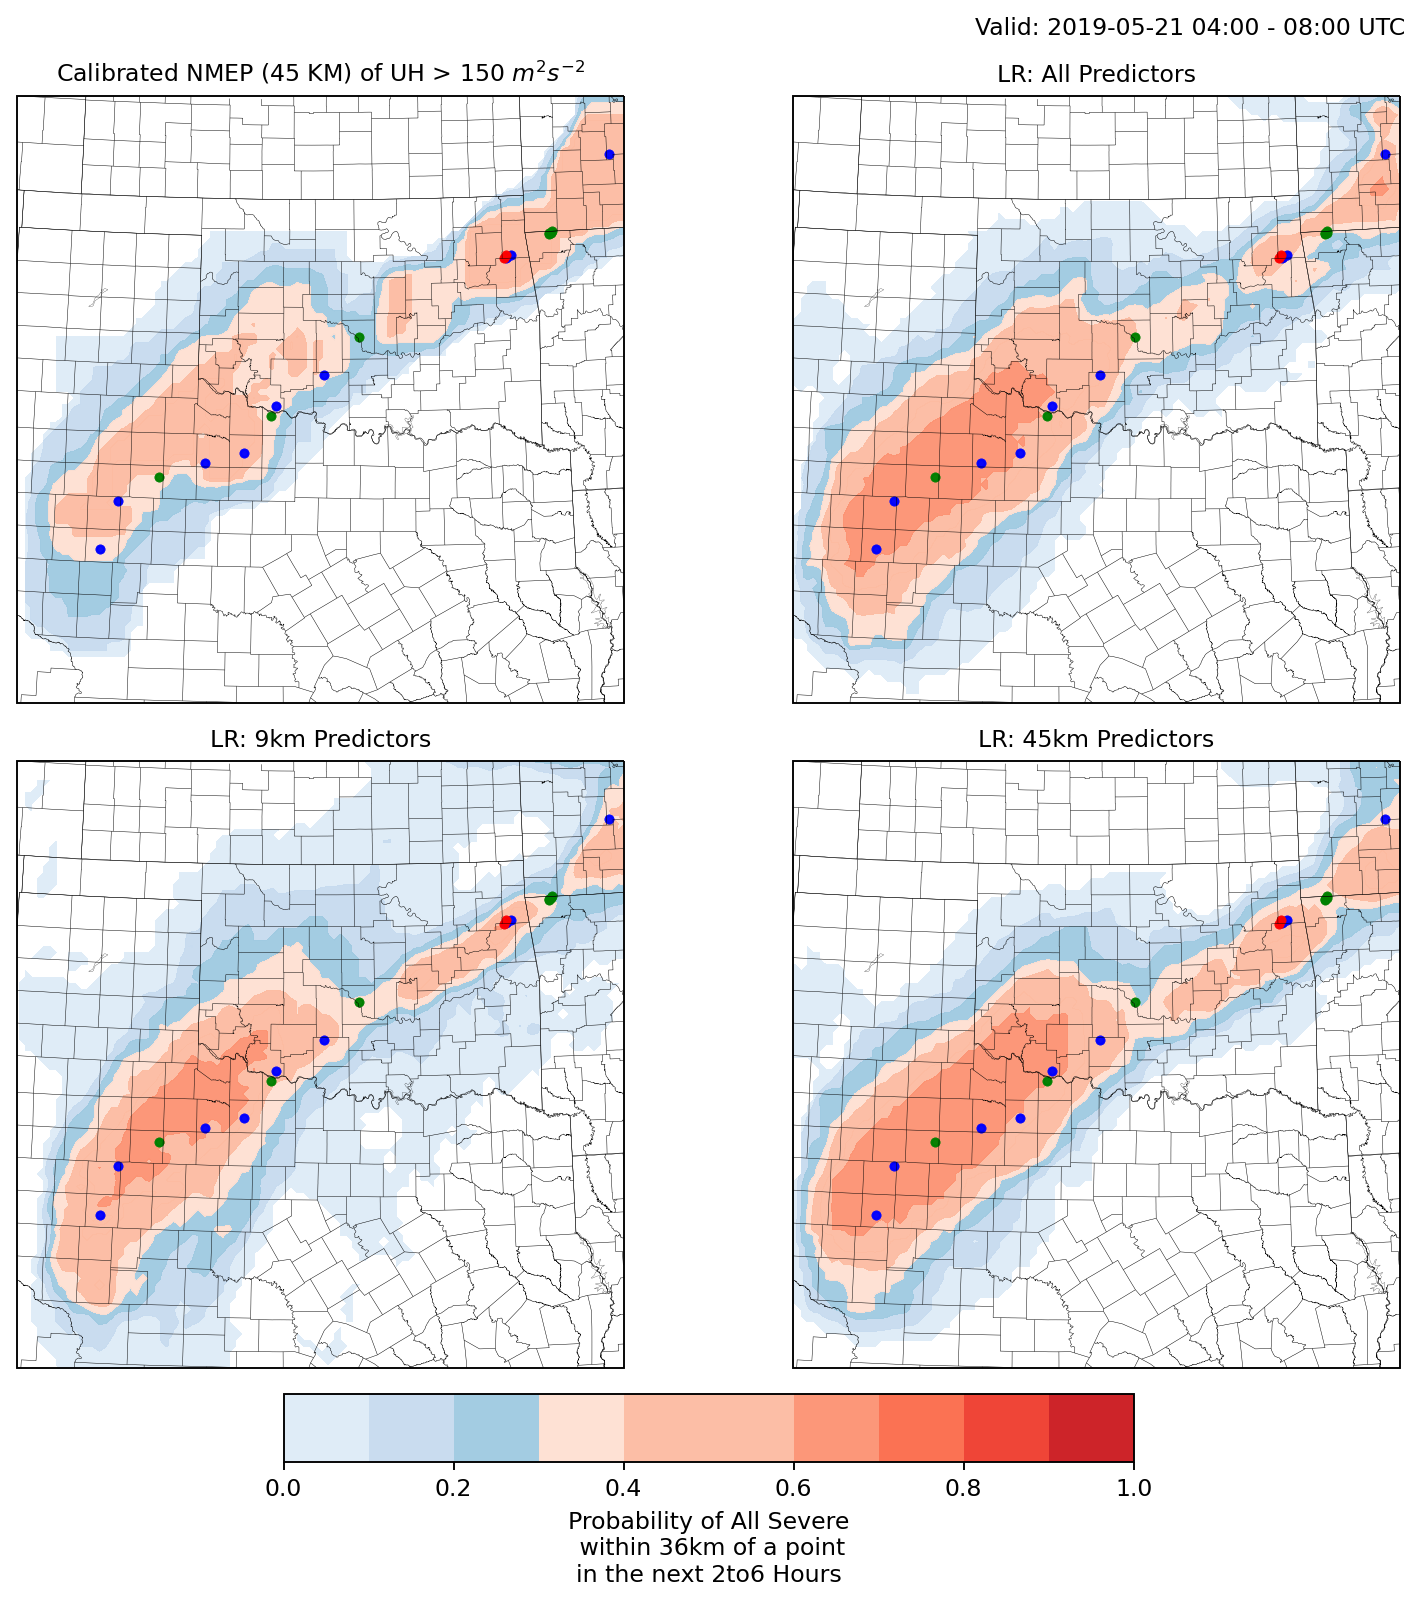

In [248]:
hazard='all'
X_9km = Drop_Unwanted_Variables(X, original=False, training_scale='9', intrastormOnly=intrastormOnly, envOnly=envOnly)[0]
X_45km =Drop_Unwanted_Variables(X, original=False, training_scale='45', intrastormOnly=intrastormOnly, envOnly=envOnly)[0]


fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=2, ncols=2, subplot_kw={'projection': projection},
                        constrained_layout=True)

models = ['BL', 'logistic', 'logistic', 'logistic'] #random/ADAM
model_names = [baseline_names[hazard], 'LR: All Predictors', 'LR: 9km Predictors', 'LR: 45km Predictors']


if hazard != 'tornado':
    levels = np.arange(0, 1.1, 0.1)
else:
    levels = np.arange(0, 0.5, 0.001)  
    
# All 3 Models and BL
for ax, model, name, t_scale in zip(axes.flat, models, model_names, ['all','all','9km','45km']):
    if model == 'BL':
        pred = get_bl_pred(X_bl, shape, hazard, scale, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE)
    elif model== 'group':
        pred=get_pseudo_all_severe_probs(X, shape, 'logistic')
    
    else:
        pred = get_ml_pred(X, shape, hazard, scale, model, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE, ts_suff=t_scale, var_suff=var_suff)
    
    add_map_stuff(ax, states, shape_feature)
    
    
    pred = np.ma.masked_where(pred<=0.025, pred)
    
    #cmap=WoFSColors.wz_cmap
    cf = ax.contourf(lons,lats, pred, cmap=WoFSColors.wz_cmap, alpha=0.95, levels=levels,
                transform = crs) 

    ##point_lat, point_lon = points[hazard]
    if hazard=='all':
        for Lorem in ['hail','wind','tornado']:
            _points=points[Lorem]
            ax.scatter(_points[:,1],_points[:,0], s=10, color=hazard_color[Lorem], alpha=0.8, zorder=1, transform=crs)
    else:
        _points = points[hazard]
        ax.scatter(_points[:,1],_points[:,0], s=900, color='k', alpha=0.8, zorder=1, transform=crs) #s=10
    
    
    ax = set_extent(ax, projection , crs, lats, lons,)
    fontsize = 10 if len(name) > 5 else 12
    ax.set_title(name, fontsize=fontsize)

fig.tight_layout()
#plt.subplots_adjust(hspace=0.2, wspace=0.0)
axes[0,1].annotate(title, (0.3, 1.1), xycoords='axes fraction', fontsize=10, color='k')

cax = fig.add_axes([0.25, -0.05, 0.5, 0.05])

fig.colorbar(cf, 
           cax=cax, 
             #label=f'Probability of any severe weather\n within {scale} of a point\nin the next 2-6 Hours',
           label=f'Probability of {titles[hazard]}\n within {scale} of a point\nin the next {TIMESCALE} Hours', 
          orientation='horizontal')

#Add 36/18/9km radius to storm reports
if False:
    for ax in axes.flat:  
        if All:
            for Lorem in ['hail','wind','tornado']:
                _points = points[Lorem]
                for pair in zip(_points[::3,1], _points[::3,0]):
                    repX, repY = circleofRadius(pair[1],pair[0], 36)
                    ax.plot(repX, repY, transform=crs, color='k', linewidth=1, alpha=0.5)
        else:
            for pair in zip(_points[:,1], _points[:,0]):
                repX, repY = circleofRadius(pair[1],pair[0], 36)
                ax.plot(repX, repY, transform=crs, color='k', linewidth=1)
plt.show()

# Predictor Category Comparison

In [ ]:
hazard='all'
X_env = Drop_Unwanted_Variables(X, original=False, training_scale=None, intrastormOnly=False, envOnly=True)[0]
X_storm =Drop_Unwanted_Variables(X, original=False, training_scale=None, intrastormOnly=True, envOnly=False)[0]


fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=2, ncols=2, subplot_kw={'projection': projection},
                        constrained_layout=True)

models = ['BL', 'logistic', 'logistic', 'logistic'] #random/ADAM
model_names = [baseline_names[hazard], 'LR: All Predictors', 'LR: Env Predictors', 'LR: Storm Predictors']


if hazard != 'tornado':
    levels = np.arange(0, 1.1, 0.1)
else:
    levels = np.arange(0, 0.5, 0.001)  
    
# All 3 Models and BL
for ax, model, name, cat in zip(axes.flat, models, model_names, ['all','control','environment','intrastorm']):
    if model == 'BL':
        pred = get_bl_pred(X_bl, shape, hazard, scale, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE)
    elif model== 'group':
        pred=get_pseudo_all_severe_probs(X, shape, 'logistic')
    
    else:
        if cat=='environment':
            pred = get_ml_pred(X_env, shape, hazard, scale, model, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE, ts_suff='all', var_suff=cat)
        elif cat=='intrastorm':
            pred = get_ml_pred(X_storm, shape, hazard, scale, model, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE, ts_suff='all', var_suff=cat)
        else:
             pred = get_ml_pred(X, shape, hazard, scale, model, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE, ts_suff='all', var_suff=cat)
    
    add_map_stuff(ax, states, shape_feature)
    
    
    pred = np.ma.masked_where(pred<=0.025, pred)
    
    #cmap=WoFSColors.wz_cmap
    cf = ax.contourf(lons,lats, pred, cmap=WoFSColors.wz_cmap, alpha=0.95, levels=levels,
                transform = crs) 

    ##point_lat, point_lon = points[hazard]
    if hazard=='all':
        for Lorem in ['hail','wind','tornado']:
            _points=points[Lorem]
            ax.scatter(_points[:,1],_points[:,0], s=10, color=hazard_color[Lorem], alpha=0.8, zorder=1, transform=crs)
    else:
        _points = points[hazard]
        ax.scatter(_points[:,1],_points[:,0], s=900, color='k', alpha=0.8, zorder=1, transform=crs) #s=10
    
    
    ax = set_extent(ax, projection , crs, lats, lons,)
    fontsize = 10 if len(name) > 5 else 12
    ax.set_title(name, fontsize=fontsize)

fig.tight_layout()
#plt.subplots_adjust(hspace=0.2, wspace=0.0)
axes[0,1].annotate(title, (0.3, 1.1), xycoords='axes fraction', fontsize=10, color='k')

cax = fig.add_axes([0.25, -0.05, 0.5, 0.05])

fig.colorbar(cf, 
           cax=cax, 
             #label=f'Probability of any severe weather\n within {scale} of a point\nin the next 2-6 Hours',
           label=f'Probability of {titles[hazard]}\n within {scale} of a point\nin the next {TIMESCALE} Hours', 
          orientation='horizontal')

#Add 36/18/9km radius to storm reports
if False:
    for ax in axes.flat:  
        if All:
            for Lorem in ['hail','wind','tornado']:
                _points = points[Lorem]
                for pair in zip(_points[::3,1], _points[::3,0]):
                    repX, repY = circleofRadius(pair[1],pair[0], 36)
                    ax.plot(repX, repY, transform=crs, color='k', linewidth=1, alpha=0.5)
        else:
            for pair in zip(_points[:,1], _points[:,0]):
                repX, repY = circleofRadius(pair[1],pair[0], 36)
                ax.plot(repX, repY, transform=crs, color='k', linewidth=1)
plt.show()

Using new variables- dropping old 90th percentile
Dropping all intrastorm variables
(10000, 78)
all
Using new variables- dropping old 90th percentile
Dropping all environmental variables
(10000, 96)
all
/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/mlModels/36km/Varga_all_logistic_all_36km_Sev_control_0.joblib
/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/mlModels/36km/Varga_all_logistic_all_36km_Sev_environment_0.joblib
/work/samuel.varga/projects/2to6_hr_severe_wx/POTVIN/mlModels/36km/Varga_all_logistic_all_36km_Sev_intrastorm_0.joblib


## Prediction Comparison

%matplotlib inline



hazard_color = {'hail' : 'g', 'wind': 'b', 'tornado': 'r'}
fig, axes = plt.subplots(figsize=(10,8), facecolor='w',
                     dpi=170, nrows=2, ncols=2, subplot_kw={'projection': projection}, 
                        constrained_layout=True)

models = ['BL', 'hist', 'logistic', 'random'] #random/ADAM
model_names = [baseline_names[hazard], 'HGBT-BL', 'LR-BL', 'RF-BL']



    
# All 3 Models and BL
for ax, model, name in zip(axes.flat, models, model_names):
    if model == 'BL':
        bl_pred = get_bl_pred(X_bl, shape, hazard, scale, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE)
        pred=bl_pred
        levels=np.arange(0,1.01,.1)
        cmap=WoFSColors.wz_cmap
        pred = np.ma.masked_where(pred<=0.025, pred) #Masks where probs < 1/40
        bl_cf = ax.contourf(lons,lats, pred, cmap=cmap, alpha=0.95, levels=levels,
                transform = crs)
    else:
        pred = get_ml_pred(X, shape, hazard, scale, model, FRAMEWORK=FRAMEWORK, TIMESCALE=TIMESCALE)-bl_pred
        pred = np.ma.masked_where(np.abs(pred)<=0.025, pred) #Masks where -1/40<pred<1/40
        levels=np.arange(-.5,.51,0.1) 
        cmap='seismic'
        cf = ax.contourf(lons,lats, pred, cmap=cmap, alpha=0.95, levels=levels,
                transform = crs)
    
    add_map_stuff(ax, states, shape_feature)
    
    
    

    ##point_lat, point_lon = points[hazard]
    if hazard=='all':
        for Lorem in ['hail','wind','tornado']:
            _points=points[Lorem]
            ax.scatter(_points[:,1],_points[:,0], s=10, color=hazard_color[Lorem], alpha=0.8, zorder=1, transform=crs)
    else:
        _points = points[hazard]
        ax.scatter(_points[:,1],_points[:,0], s=900, color='k', alpha=0.8, zorder=1, transform=crs) #s=10
    
    
    ax = set_extent(ax, projection , crs, lats, lons,)
    fontsize = 10 if len(name) > 5 else 12
    ax.set_title(name, fontsize=fontsize)

fig.tight_layout()
#plt.subplots_adjust(hspace=0.2, wspace=0.0)
axes[0,1].annotate(title, (0.3, 1.1), xycoords='axes fraction', fontsize=10, color='k')

cax = fig.add_axes([0.25, -0.05, 0.5, 0.05])
fig.colorbar(cf, 
           cax=cax, 
           label=f'Difference from Baseline Probability', 
          orientation='horizontal')

blcax=fig.add_axes([0,0.51,0.040,0.45])
bl_cb=fig.colorbar(bl_cf, cax=blcax, orientation='vertical' )
bl_cb.set_label(f'Probability of {titles[hazard]} within {scale} of a point',labelpad=2)